In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def set_fontsize(ax, fs):
    """
    Small function to set font sizes for figures
    """
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.title.set_size(fs)

In [89]:
%%time
from quantumoperators import *
from hamiltonianoperators import *

Jmax = 6      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

HamiltonianJ6 = Hamiltonian(Jmax, I_Tl, I_F)

Wall time: 55.9 s


# Loading Trajectories and Fields

In [7]:
from trajectories import *
positions = load_trajectories('positions_545.mat')
velocities = load_velocities('velocities_545.mat')

t, (xT, yT, zT), (xVelocity, yVelocity, zVelocity) = get_time_position_velocity(positions, velocities)

In [9]:
interpolateTrajectories = []
for idInt in range(t.shape[1]):
    interpolateTrajectories.append((make_interpolate(t[:,idInt], xT[:,idInt], yT[:,idInt], zT[:,idInt])))
    
del t, xT, yT, zT, xVelocity, yVelocity, zVelocity

In [11]:
from fields import *
c, intfun = fit_potential_xyz('potentialQuadrupole.fld', 0.022, 0.019, 0, 0)
cP, intfunP = fit_potential_xyz('potentialElectrodes.fld', 0.022, 0.019, .45, 0)

C:\Users\Olivier\Dropbox\Postdoc\Yale\CeNTREX Olivier\TlF Non-Adiabatic Transitions\fields.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(vander, f)[0]


# Propagation

### Changing Homogeneous Electric Field Strength

First check which level is the starting level.

Want to start in J=2, mj=0, -0.5, -0.5.

In [90]:
idT = 1
traj = interpolateTrajectories[idT]
xi, yi, zi = traj[0](0), traj[1](0), traj[2](0)
B0 = 20
Efactor = np.arange(0,5.5,.5)

for E0 in Efactor:
    print('*'*50)
    print('{0:.0f} V/cm'.format(E0*83))
    funEx, funEy, funEz, funEmag = combine_quadrupole_plate_factor(c, intfun, cP, intfunP, E0)
#     funE = lambda x,y,z: (funEx(x,y,z), funEy(x,y,z), funEz(x,y,z))
#     funB = lambda x,y,z: (0, B0, 0)
    funE = lambda x,y,z: (0,0, funEmag(x,y,z))
    funB =  lambda x,y,z: (0, 0, B0)
#     HamiltonianJ6.largest_eigenstate(*funE(xi,yi,zi), *funB(xi,yi,zi), J = 2, epsilon = 0.9)
    HamiltonianJ6.level_eigenstates(*funE(xi,yi,zi), *funB(xi,yi,zi), level = [33,34,35], epsilon = 0.99)

**************************************************
0 V/cm
-----------------------
Level = 33
E = +4.0139698632511154e+07 kHz
	-1.000 +0.000i 2 +0 -0.5 -0.5
-----------------------
Level = 34
E = +4.0139713013892412e+07 kHz
	+1.000 +0.000i 2 -1 -0.5 -0.5
-----------------------
Level = 35
E = +4.0139726662079640e+07 kHz
	+1.000 +0.000i 2 -2 -0.5 -0.5
**************************************************
42 V/cm
-----------------------
Level = 33
E = +4.0139704619772591e+07 kHz
	-1.000 +0.000i 2 +0 +0.5 -0.5
-----------------------
Level = 34
E = +4.0139719940255530e+07 kHz
	-1.000 +0.000i 2 -1 -0.5 -0.5
-----------------------
Level = 35
E = +4.0139720760475844e+07 kHz
	-1.000 +0.000i 2 +0 -0.5 -0.5
**************************************************
83 V/cm
-----------------------
Level = 33
E = +4.0139748011692390e+07 kHz
	-1.000 +0.000i 2 -1 -0.5 -0.5
-----------------------
Level = 34
E = +4.0139772000188880e+07 kHz
	+1.000 +0.000i 2 +0 +0.5 -0.5
-----------------------
Level = 35
E = +

At 0 V/cm the start level is 33, all others have 35 as start level.

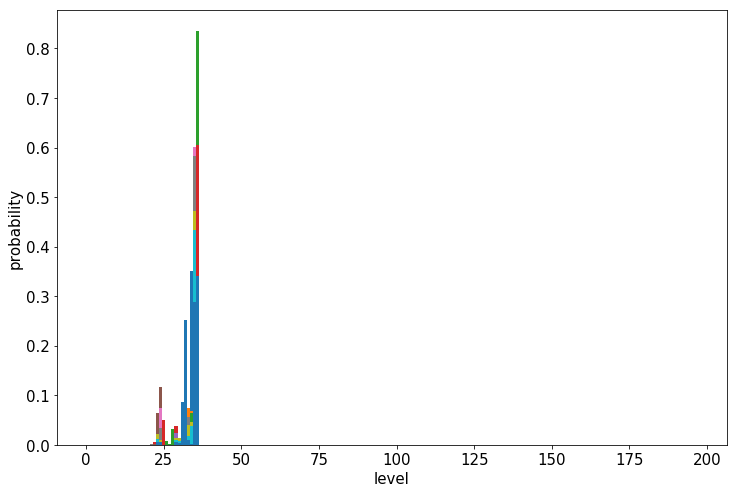

In [91]:
from tqdm import tqdm_notebook as tqdm
from propagation import *

idT = 1
Efactor = np.arange(0,5.5,0.5)
B0 = 20

probabilities_electricfield = []
start_levels = [33]+[35]*10

fig, ax = plt.subplots(figsize = (12,8))
for l0, E0 in tqdm(zip(start_levels, Efactor), total = len(Efactor)):
    funEx, funEy, funEz, funEmag = combine_quadrupole_plate_factor(c, intfun, cP, intfunP, E0)
    funB =  lambda x,y,z: (0, B0, 0)
    funE = lambda x,y,z: (funEx(x,y,z), funEy(x,y,z), funEz(x,y,z))
    t, H, phi = propagate_adaptive_save(HamiltonianJ6.create_hamiltonian, interpolateTrajectories[idT], funE, funB, l0, 
                                        dtAdaptive = (5e-7, 1e-6), nstep = 2)
    probabilities = calculate_state_probabilities(phi[-1], H[0])

    ax.bar(np.arange(1,len(probabilities)+1),probabilities, width = 1, label = '{0:.0f} V/cm'.format(83*B0))
    probabilities_electricfield.append(np.abs(phi[-1].conj()@phi[0])**2)

ax.set_xlabel('level')
ax.set_ylabel('probability');
set_fontsize(ax, 15)

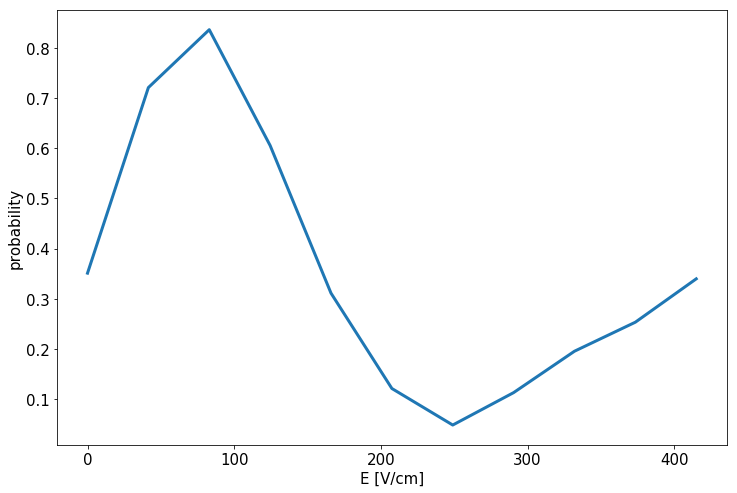

In [92]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(Efactor*83, probabilities_electricfield, lw = 3)
ax.set_xlabel('E [V/cm]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)

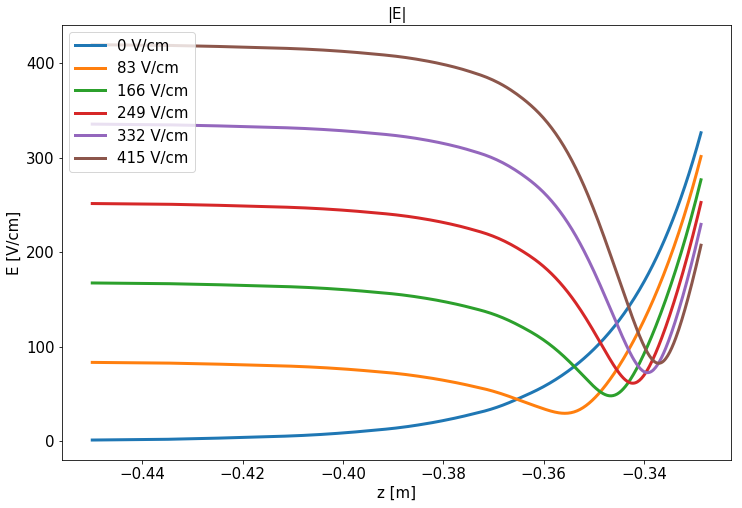

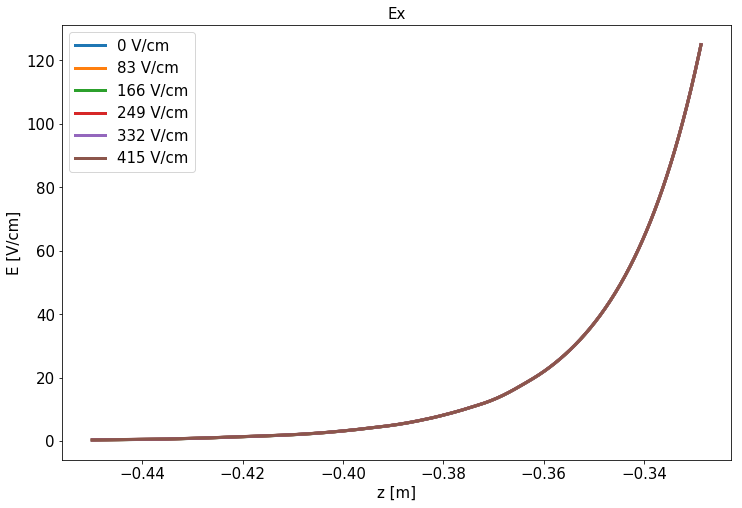

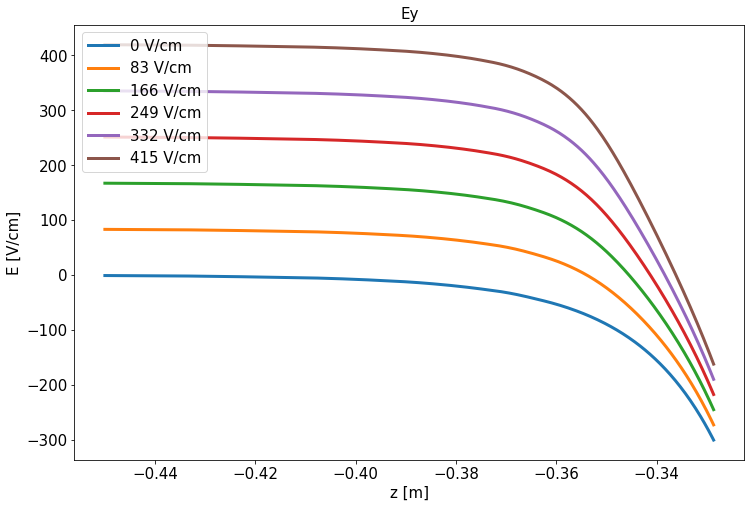

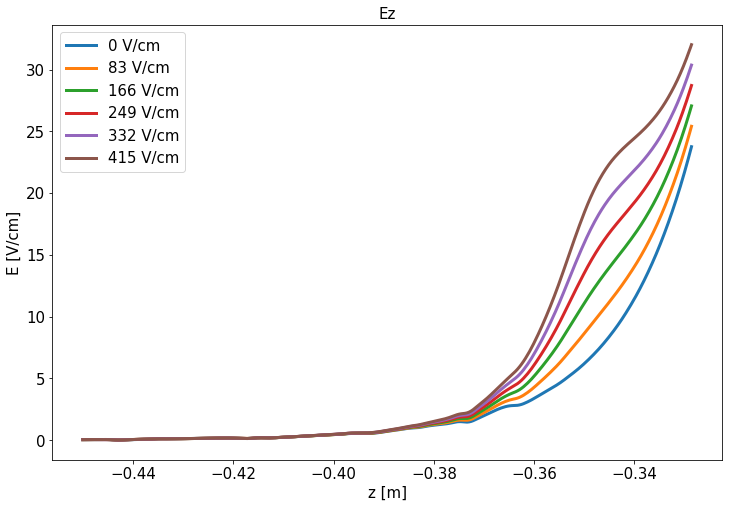

In [44]:
idT = 1
traj = interpolateTrajectories[idT]
xi, yi, zi = traj[0](t), traj[1](t), traj[2](t)
Efactor = np.arange(0,5.5,1)

nstart, nstop = 0,380

fig, ax = plt.subplots(figsize = (12,8))
for E0 in Efactor:
    funEx, funEy, funEz, funEmag = combine_quadrupole_plate_factor(c, intfun, cP, intfunP, E0)
    ax.plot(zi[nstart:nstop], funEmag(xi,yi,zi)[nstart:nstop], lw = 3, label = '{0:.0f} V/cm'.format(E0*83))
ax.set_title('|E|')
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.legend(fontsize = 15, loc = 2)
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
for E0 in Efactor:
    funEx, funEy, funEz, funEmag = combine_quadrupole_plate_factor(c, intfun, cP, intfunP, E0)
    ax.plot(zi[nstart:nstop], funEx(xi,yi,zi)[nstart:nstop], lw = 3, label = '{0:.0f} V/cm'.format(E0*83))
ax.set_title('Ex')
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.legend(fontsize = 15, loc = 2)
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
for E0 in Efactor:
    funEx, funEy, funEz, funEmag = combine_quadrupole_plate_factor(c, intfun, cP, intfunP, E0)
    ax.plot(zi[nstart:nstop], funEy(xi,yi,zi)[nstart:nstop], lw = 3, label = '{0:.0f} V/cm'.format(E0*83))
ax.set_title('Ey')
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.legend(fontsize = 15, loc = 2)
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
for E0 in Efactor:
    funEx, funEy, funEz, funEmag = combine_quadrupole_plate_factor(c, intfun, cP, intfunP, E0)
    ax.plot(zi[nstart:nstop], funEz(xi,yi,zi)[nstart:nstop], lw = 3, label = '{0:.0f} V/cm'.format(E0*83))
ax.set_title('Ez')
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.legend(fontsize = 15, loc = 2)
set_fontsize(ax, 15)

In [19]:
from tqdm import tqdm_notebook as tqdm

B0 = 20

Efactor = np.arange(0.5,3,0.5)

traj = interpolateTrajectories[idT]
xi, yi, zi = traj[0](t), traj[1](t), traj[2](t)
Bxi, Byi, Bzi = np.zeros(len(t)), B0*np.ones(len(t)), np.zeros(len(t))

energies_electricfield = []
eigenvectors_electricfield = []
for E0 in tqdm(Efactor):
    funEx, funEy, funEz, funEmag = combine_quadrupole_plate_factor(c, intfun, cP, intfunP, E0)
    funE = lambda x,y,z: (funEx(x,y,z), funEy(x,y,z), funEz(x,y,z))
    (Exi, Eyi, Ezi) = funE(xi,yi,zi) 
    H = HamiltonianJ6.create_hamiltonian(Exi, Eyi, Ezi, Bxi, Byi, Bzi)
    energies, eigenvectors = np.linalg.eigh(H)
    energies_electricfield.append(energies)
    eigenvectors_electricfield.append(eigenvectors)

In [26]:
from ipywidgets import interact, interactive, IntSlider

props = dict(boxstyle = 'round', facecolor = 'white', alpha = 1)
nstart, nstop =  0, len(t)

def update(idE):
    fig, ax = plt.subplots(figsize = (12,8))
    for idL in range(26,36):
        ax.plot(zi[nstart:nstop], energies_electricfield[idE][:,idL][nstart:nstop] - \
                energies_electricfield[idE][:,35][nstart:nstop], 
                lw = 3, label = 'level {0}'.format(idL+1))
    textstr = 'E = {0} V/cm'.format(Efactor[idE]*83)
    ax.text(0.05, 0.08, textstr, transform=ax.transAxes, fontsize=15,
            va='top', bbox=props, ha = 'left')
    textstr = '{0:.1f}%'.format(probabilities_electricfield[idE+1]*100)
    ax.text(0.95, 0.08, textstr, transform=ax.transAxes, fontsize=15,
            va='top', bbox=props, ha = 'right')
    ax.set_xlabel('z [m]')
    ax.set_ylabel('energy')
    ax.legend(fontsize = 15, loc = 8)
    set_fontsize(ax, 15)
    ax.set_ylim(ymin = -3e4, ymax = 1e3)
    fig.canvas.draw()

In [27]:
interact(update, idE = IntSlider(min=0,max=len(Efactor)-1,step=1,value=0));

interactive(children=(IntSlider(value=0, description='idE', max=4), Output()), _dom_classes=('widget-interact'…

# Displacing the electrodes longitudinally

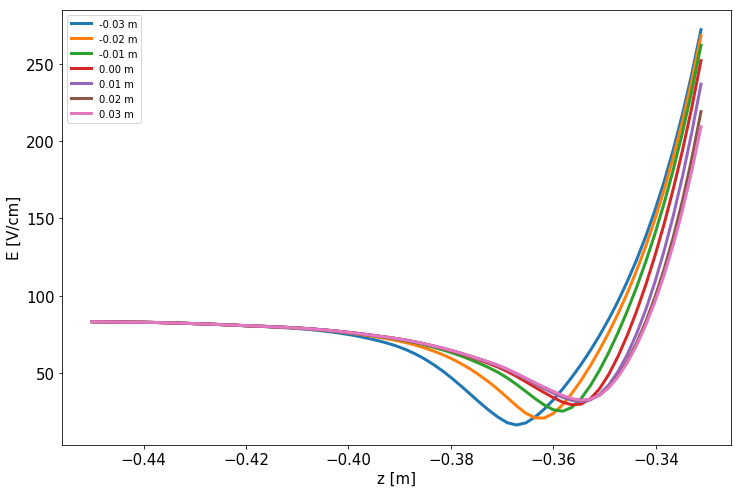

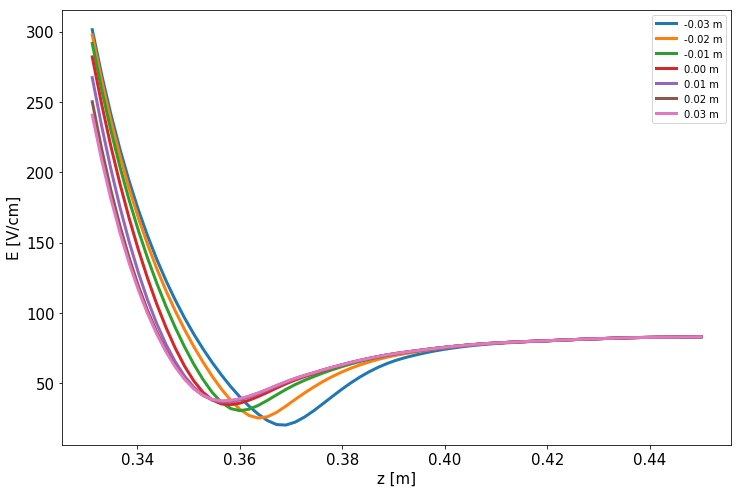

In [125]:
from fields import *
from tqdm import tqdm_notebook as tqdm
from propagation import *

idT = 1
displacement = np.arange(-0.03,0.032,0.01)
B0 = 20

probabilities_electricfield = []
start_levels = [35]*len(displacement)

fig, ax = plt.subplots(figsize = (12,8))
fig1, ax1 = plt.subplots(figsize = (12,8))

for di in tqdm(displacement):
    intfunDisplaced = potential_plate_z_offset('potentialElectrodes.fld', 0.019, 0, di)
    funEx, funEy, funEz, funEmag = combine_quadrupole_plate(c, intfun, cP, intfunDisplaced)    
    funE = lambda x,y,z: (funEx(x,y,z), funEy(x,y,z), funEz(x,y,z))
    traj = interpolateTrajectories[idT]
    t = np.linspace(0,traj[3], 501)
    xi, yi, zi = traj[0](t), traj[1](t), traj[2](t)
    m = zi < -0.33
    m1 = zi > 0.33
    ax.plot(zi[m], funEmag(xi,yi,zi)[m], label = '{0:.2f} m'.format(di), lw = 3)
    ax1.plot(zi[m1], funEmag(xi,yi,zi)[m1], label = '{0:.2f} m'.format(di), lw = 3)
    
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.legend();
set_fontsize(ax, 15)

ax1.set_xlabel('z [m]')
ax1.set_ylabel('E [V/cm]')
ax1.legend();
set_fontsize(ax1, 15)

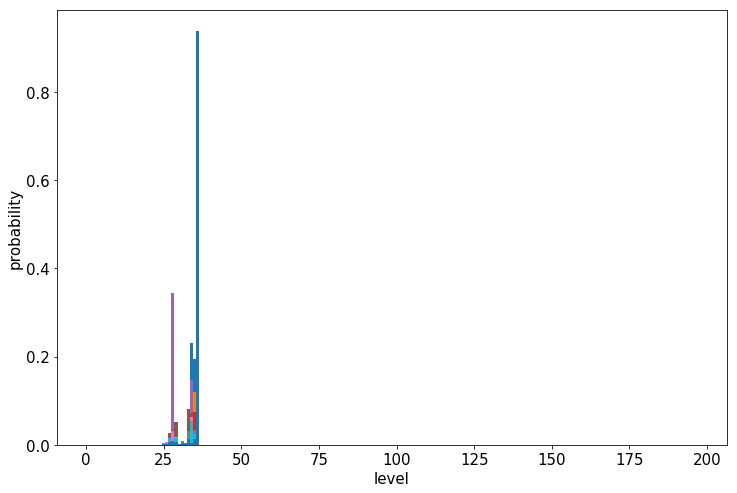

In [122]:
from fields import *
from tqdm import tqdm_notebook as tqdm
from propagation import *

idT = 1
displacement = np.arange(-0.06,0.042,0.01)
B0 = 20

probabilities_displacement = []
start_levels = [35]*len(displacement)

fig, ax = plt.subplots(figsize = (12,8))

for di in tqdm(displacement):
    intfunDisplaced = potential_plate_z_offset('potentialElectrodes.fld', 0.019, 0, di)
    funEx, funEy, funEz, funEmag = combine_quadrupole_plate(c, intfun, cP, intfunDisplaced)    
    funB =  lambda x,y,z: (0, B0, 0)
    funE = lambda x,y,z: (funEx(x,y,z), funEy(x,y,z), funEz(x,y,z))
    t, H, phi = propagate_adaptive_save(HamiltonianJ6.create_hamiltonian, interpolateTrajectories[idT], funE, funB, l0, 
                                        dtAdaptive = (5e-7, 1e-6), nstep = 2)
    probabilities = calculate_state_probabilities(phi[-1], H[0])

    ax.bar(np.arange(1,len(probabilities)+1),probabilities, width = 1, label = '{0:.0f} V/cm'.format(83*B0))
    probabilities_displacement.append(np.abs(phi[-1].conj()@phi[0])**2)

ax.set_xlabel('level')
ax.set_ylabel('probability');
set_fontsize(ax, 15)

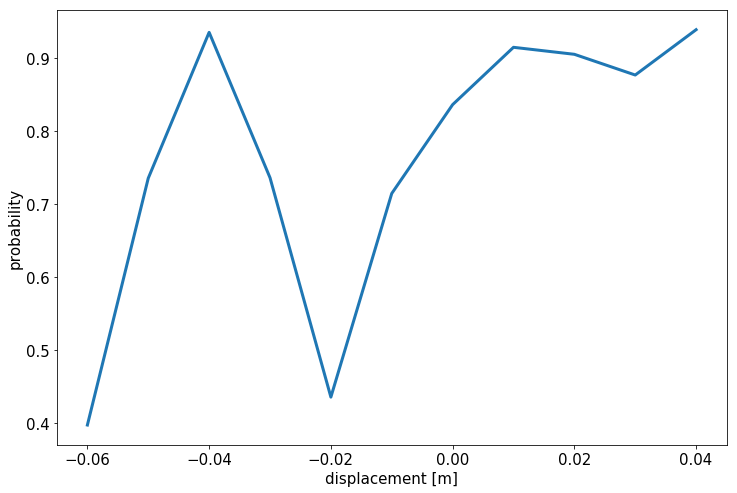

In [123]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(displacement, probabilities_displacement, lw = 3)
ax.set_xlabel('displacement [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)

### Increase magnetic field to 30 G

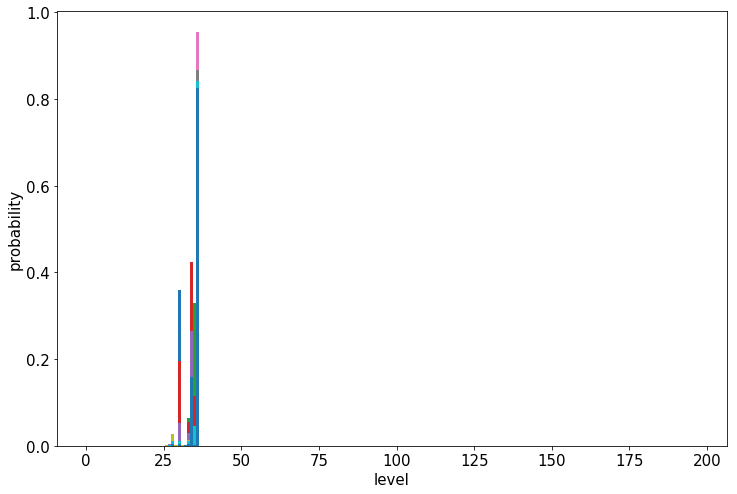

In [126]:
from fields import *
from tqdm import tqdm_notebook as tqdm
from propagation import *

idT = 1
displacement = np.arange(-0.06,0.042,0.01)
B0 = 30

probabilities_displacement = []
start_levels = [35]*len(displacement)

fig, ax = plt.subplots(figsize = (12,8))

for di in tqdm(displacement):
    intfunDisplaced = potential_plate_z_offset('potentialElectrodes.fld', 0.019, 0, di)
    funEx, funEy, funEz, funEmag = combine_quadrupole_plate(c, intfun, cP, intfunDisplaced)    
    funB =  lambda x,y,z: (0, B0, 0)
    funE = lambda x,y,z: (funEx(x,y,z), funEy(x,y,z), funEz(x,y,z))
    t, H, phi = propagate_adaptive_save(HamiltonianJ6.create_hamiltonian, interpolateTrajectories[idT], funE, funB, l0, 
                                        dtAdaptive = (5e-7, 1e-6), nstep = 2)
    probabilities = calculate_state_probabilities(phi[-1], H[0])

    ax.bar(np.arange(1,len(probabilities)+1),probabilities, width = 1, label = '{0:.0f} V/cm'.format(83*B0))
    probabilities_displacement.append(np.abs(phi[-1].conj()@phi[0])**2)

ax.set_xlabel('level')
ax.set_ylabel('probability');
set_fontsize(ax, 15)

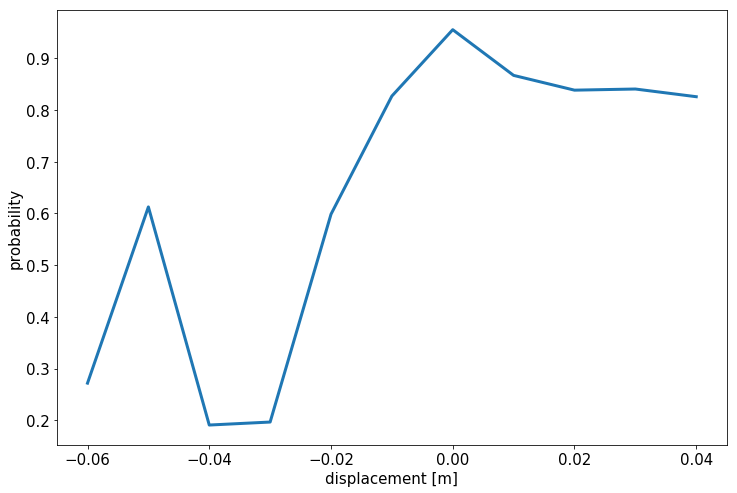

In [127]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(displacement, probabilities_displacement, lw = 3)
ax.set_xlabel('displacement [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)